## CLIP fine-tuning
The idea of fine-tuninig can be borrowed from "contrastive learning" approach. We will not assing any numbers to prohos with an intent to make a regression later. We are going to find a master-vector in emdedding space that can rate photos by a scalar product and produce photo orderings that are in line with the ordering produced by human.  
If a photo that has embedding $\overrightarrow{x}_1$ is better than a photo with embedding $\overrightarrow{x}_2$ then  
$$\overrightarrow{w}\cdot\overrightarrow{x}_1 > \overrightarrow{w}\cdot\overrightarrow{x}_2$$

If we have 1000 photos then we can surely anticipate that it is absolutely impossible to sort them confindently by their visual attractiveness. One can sort photos only partially: divide then into around 3-15 tiers. And in each tier all photos are equally good/bad.
Let's follow a convention that the best tier (professional photos) has index 0. The worst tier (boring photos) has some big index (in this particular experiment - 14. So, if the formula above is true if:  
$$t_1 < t_2$$  
But if we re-write the expression for ratings like this:
$$\overrightarrow{w}\cdot(\overrightarrow{x}_1 - \overrightarrow{x}_2) > 0$$
then we notice that now we can do a conventional classification, but with differences of embeddings.

## Mathematical formulation
The classification problem statement from above is very similar to the problem statement for Support Vector Classification. In my humble oppinion, the best explanation of SVM formalizm is given in _C.M. Bishop - Pattern Recognition and Machine Learning, Springer, 2016, p.p. 325-335_. Major ideas elaborated below are borrowed from this source.

We are going to work with learning examples being differences between photo embeddings. Let's denote them by $\phi$, thus making $\phi = \overrightarrow{x}_2 - \overrightarrow{x}_1$.
Following _Bishop_, we formulate a constrained optimization task. We are looking for a separating plane between 2 classes with the greatest margin. The signed distance between a point and a plane is just a normalized scalar product $w^T\phi_n/\|w\|$ (Bishop considers a more general case with the intercept term, but our particular task is a bit simpler in this narrow sence). And in the simplest case of separable dataset the task is formulated as
$$ \mathop{arg\,max}_{w}\{\frac{1}{\|w\|}\mathop{min}_{n}[t_nw^T\phi_n]\} $$
that is equivalent to
$$ \mathop{arg\,min}_{w}\frac{1}{2}\|w\|^2 $$
subject to constraints:
$$ t_nw^T\phi \geq 1 $$
In a more general case of non-separable dataset formalizm introduces so-called slack variables that are also constrained. The mechanizm that underlies slack variables is quite complex and we will ommit all technical details that are explained by Bishop. The optimization task in the case of non-separable dataset is the following:
$$ \mathop{arg\,min}_{w, \xi, \zeta}(C(\sum\limits_{i=1}^N\xi_n + \sum\limits_{k \in K}\zeta_k) + \frac{1}{2}\|w\|^2) $$
subject to constraint:
$$ t_mw^T\phi_m \geq 1 - \xi_m $$
$$ t_kw^T\phi_k = \xi_m - \zeta_k $$
$$ \xi_n \geq 0 $$
$$ \zeta_k \geq 0 $$
Where indexing from $1$ to $N$ spans all examples, set $M$ comprises only examples with definite label (+1 - a photo 1 is better then photo 2 OR -1 - photo 1 is worse then photo 2), set $K$ comprises only examples with dubious labeling (0 - photo 1 is equally valuable with the photo 2). $\xi$ and $\zeta$ are the slack variables. $C$ is a parameter that controls the regularization strength (the higher the $C$ the weaker is the reqularization).
Bishop considered a narrower case of conventional SVMs in a sence that they don't allow "neutral" (0-labelled) examples. In a perfect setting of a separable dataset such examples are meant to lie on the separating plane (and without slack variables a corresponding constraint would just be $t_kw^T\phi_k = 0$. But we here are dealing with a bit more complex and more business-case-specific task, that's why we don't just resort to SVM from sklearn package.
The tasks of this kind are referred to as __Quadratic programming__. They are resolved by composing a Lagrangian function with the use of [Karush-Kuhn-Tucker conditions](https://en.wikipedia.org/wiki/Karush%E2%80%93Kuhn%E2%80%93Tucker_conditions):
$$ L(w, a) = \frac{1}{2}\|w\|^2 + C(\sum\limits_{i=1}^N\xi_n + \sum\limits_{k \in K}\zeta_k) - \sum\limits_{m \in M}a_m\{t_mw^T\phi_m - 1 + \xi_m\} + \sum\limits_{k \in K}a_k\{t_kw^T\phi_m - \xi_m + \zeta_k\} - \sum\limits_{n=1}^N\mu_n\xi_n - \sum\limits_{k \in K}\rho_k\zeta_k$$
subject to constraints:
$$ a_n \geq 0 $$
$$ \mu_n \geq 0 $$
$$ \xi_n \geq 0 $$
$$ \rho_k \geq 0 $$
$$ \zeta_k \geq 0 $$
$$ \mu_n\xi_n = 0 $$
$$ \rho_k\zeta_k = 0 $$
A saddle point of this function should be found. That saddle point minimizes with respect to $w$ and maximizes with respect to $a_n$. It is easy to eliminate $w$ from the Lagrangian by setting $\frac{\partial L}{\partial w} = 0 $ and expressing $w$ through $a$`s.
$$ w = \sum\limits_{m \in M}a_mt_m\phi_m - \sum\limits_{k \in K}a_k\phi_k $$
Derivatives over slack variables allow us to simplity constraints:
$$ \frac{\partial L}{\partial \xi_n} = 0  \Longrightarrow  \mu_n = C - a_n $$
$$ \frac{\partial L}{\partial \zeta_k} = 0  \Longrightarrow  \rho_k = C + a_k $$
Later 2 expressions allow to reduce the complexity of original constraints down to "box"-type constraints (below they are written in the form that is ready-to-use in CVXOPT package):
$$ -a_m \leq 0 $$
$$ a_m \leq C $$
$$ -a_k \leq C $$
$$ a_k \leq C $$
Dual (in terms of $a_n$'s) representation of Lagrangian takes the form:
$$ \tilde{L}(a) = \sum\limits_{m \in M}a_m - \frac{1}{2}L_{MM} + L_{KM} - \frac{1}{2}L_{KK} $$
where
$$ L_{MM} = \sum\limits_{i \in M}\sum\limits_{j \in M}a_ia_jt_it_j\phi_i\phi_j $$
$$ L_{KM} = \sum\limits_{i \in M}\sum\limits_{j \in K}a_ia_jt_i\phi_i\phi_j $$
$$ L_{KK} = \sum\limits_{i \in K}\sum\limits_{j \in K}a_ia_j\phi_i\phi_j $$
One can notice that it is indexed formulation of a quadratic form $a_n^TQa_n$. Interesting to note that $L_{KM}$ appears in the expression without $1/2$ factor and with + sign. It is a cross-term that corresponds to 2 parts of the matrix $Q$ while MM and KK terms correspond only to 1 term each, that's why contribution of KM is doubled. Another interesting observation is that since KM term lacks the multiplier $t_k$ (because this zero-tag is treated exlusively), the minus sign before $L_{KM}$ can be interpreted as effective sign of $t_k$. At the 1st glance it seems asymmetric. One can ask a question "why this sign is not +?" The answer is that we have a freedon in picking up the sign before the 4th term in Lagrangian (tha corresponds to "neutral" examples). If we picked up "-" sign before that term, then we would have "+1" sign as fallback label for neutral examples here (but then box constraints would be also affected).
Casting dual Lagrangian expression into a matrix form we get
$$ \tilde{L}(a) = \sum\limits_{m \in M}a_m + a^TQa $$
$$ Q = -\frac{1}{2}v\times v^T $$
$$ v = \tilde{t}\circ\phi $$
The $\circ$ sign in the last expression means element-wise product of 2 vectors producing a vector with the same dimensions.

And the dual Lagrangian is not minimized, but maximized. Below we use CVXOPT, that can do only minimization, so, to make this formulation CVXOPT-compliant, we just multiply enire dual Lagrangian by -1:
$$ \tilde{L}(a) = -\sum\limits_{m \in M}a_m + a^TQa $$
$$ Q = \frac{1}{2}v\times v^T $$
$$ v = \tilde{t}\circ\phi $$

In [14]:
import os
import pprint
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from PIL import Image
from transformers import AutoProcessor, AutoTokenizer, CLIPVisionModelWithProjection, CLIPTextModelWithProjection
import torch

from cvxopt import matrix
from cvxopt.solvers import qp

DATASET_DIR = 'stpx_dataset'
PROJECTED_VISUAL_EMBDEDDINGS = True  # Whether we find a data-centric master-vector in 512-dimensional space.

files_2_tiers = {}
display = {}  # this dict doesn't go anywhere, it's just for concise output of this cell
for d in os.listdir(DATASET_DIR):
    for fname in os.listdir(os.path.join(DATASET_DIR, d)):
        files_2_tiers[os.path.join(DATASET_DIR, d, fname)] = int(d)
    display[os.path.join(DATASET_DIR, d, fname)] = int(d)
pprint.pprint(display)
print('Number of photos: {}'.format(len(files_2_tiers)))

{'stpx_dataset/00/Astronomy.jpg': 0,
 'stpx_dataset/01/petersburg.jpg': 1,
 'stpx_dataset/02/butterfly.jpg': 2,
 'stpx_dataset/03/interesting_orientation.jpg': 3,
 'stpx_dataset/04/amateur_flamenco01.jpg': 4,
 'stpx_dataset/05/women_meeting.jpg': 5,
 'stpx_dataset/06/overlighted_sky.jpg': 6,
 'stpx_dataset/07/pumpkin.jpg': 7,
 'stpx_dataset/08/strange_photo01.jpg': 8,
 'stpx_dataset/09/concert_too_many_people.jpg': 9,
 'stpx_dataset/10/non_informative_patch.jpg': 10,
 'stpx_dataset/11/oblique_horizon1.jpg': 11,
 'stpx_dataset/12/photo_from_airplane.jpg': 12,
 'stpx_dataset/13/dark_photo.jpg': 13,
 'stpx_dataset/14/boring_photo01.jpg': 14}
Number of photos: 79


the cell above outlies how dataset looks like. It has 15 directories. The directory with higher number is believed to store worse photos than any directory with lower number.

In [16]:
model = CLIPVisionModelWithProjection.from_pretrained("openai/clip-vit-base-patch32")

visual_projection_layer = model.get_submodule('visual_projection')
# visual projection layer projects 768-dim space onto 512-dim space. If we face problems with too high computational costs,
# we will fall back to using projected dimensions

model = model.get_submodule('vision_model')
# vision model produces 768-dimensional embeddings. They might be more semantically informative

text_encoder = CLIPTextModelWithProjection.from_pretrained("openai/clip-vit-base-patch32")

processor = AutoProcessor.from_pretrained("openai/clip-vit-base-patch32")
tokenizer = AutoTokenizer.from_pretrained("openai/clip-vit-base-patch32")

In [17]:
def project_vis_embedding(vector):
    return visual_projection_layer(torch.from_numpy(vector.astype(np.float32))).detach().numpy()

def get_embedding(fname, is_low_dim = False):
    image1 = Image.open(fname)
    inputs = processor(images=image1, return_tensors="pt")
    high_dim_output = model(**inputs).pooler_output.detach().numpy()[0]
    if is_low_dim:
        return project_vis_embedding(high_dim_output)
    else:
        return high_dim_output

The cell below builds a set of examples. As some shallow empiric study shows, text-prompt-based master-vectors and data based ones become more aligned when we limit a difference between photo tiers. So, this cell introduces a constant THRESHOLD_TIER_DIFFERENCE.
This constraint doesn't waste any data, because anyways, the rank of Q-matrix cannot be higher than the amount of photos. Below we check if the rank is preserved.

In [40]:
THRESHOLD_TIER_DIFFERENCE = 6
files_2_tiers_decomposed = list(files_2_tiers.items())
deltas = []
labels = []

for i, (f1, t1) in tqdm(enumerate(files_2_tiers_decomposed[:-1]), total=len(files_2_tiers_decomposed) - 1):
    pooled_output1 = get_embedding(f1, PROJECTED_VISUAL_EMBDEDDINGS)
    for f2, t2 in files_2_tiers_decomposed[(i + 1):]:
        if (t2 == 0 and t1 == 0 and i == 0) or (abs(t2 - t1) > THRESHOLD_TIER_DIFFERENCE):
            # the part with top-tier in if expression means that all professional photos are certainly equally good
            # regardless of the taste of a person that composed a dataset, so corresponding neutral examples are very reliable
            # and worth introducing into a dataset regardless of THRESHOLD_TIER_DIFFERENCE value.
            pooled_output2 = get_embedding(f2, PROJECTED_VISUAL_EMBDEDDINGS)
            diff_emb = pooled_output1 - pooled_output2
            diff_tag = t2 - t1
            
            deltas.append(diff_emb)
            labels.append(diff_tag)
            # At the 1st glance it looks like we have a malformed task since we could add -diff_emb and -diff_tag
            # and it would still be correct, but this kind of data augmentation would contribute nothing since
            # our particular task has no intercept term, so we allow only separating plane rotation around a coordinates center.
            # That in turn means that we actually have a correct inductional bias that class lables are anti-symmetric
            # with respect to their vectors, so even if we had only "+1"-labeled examples, our approach would still work.
            
labels = np.sign(labels)

sorted_inds = np.argsort((labels == 0).astype(np.int8))  # same-class examples will be at high indices
deltas = np.vstack(deltas)[sorted_inds, :]
labels = labels[sorted_inds]

100%|███████████████████████████████████████████| 78/78 [03:30<00:00,  2.69s/it]


(array([603.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 547.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <BarContainer object of 10 artists>)

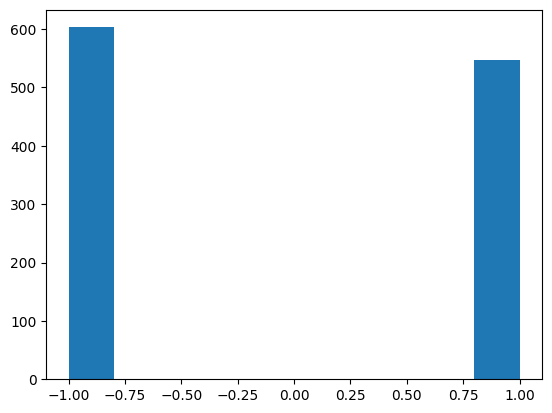

In [43]:
plt.hist(labels)

In [44]:
deltas.shape

(1150, 512)

Below we precompute matrices and vectors for supplying them to solver.

In [45]:
C = 0.5  # reciprocal regularization strength
corrected_labels = labels.copy()
corrected_labels[corrected_labels == 0] = -1
v = np.vstack([corrected_labels] * deltas.shape[1]).T * deltas
Q = 0.5 * v @ v.T
r = - (labels != 0).astype(np.float64)

neg_a_matr = - np.eye(labels.shape[0])
neg_a_vec = np.zeros(labels.shape[0])
neg_a_vec[labels == 0] = C

pos_a_matr = np.eye(labels.shape[0])
pos_a_vec = np.ones(labels.shape[0]) * C

box_constraints_matr = np.vstack([neg_a_matr, pos_a_matr])
box_constraints_vec = np.hstack([neg_a_vec, pos_a_vec])

In [46]:
np.linalg.matrix_rank(Q)

78

In [47]:
# Q should be positive semidefinite for convex optimization problem to be reliably solvable with standard means:
if not np.all(np.linalg.eigvals(Q) >= 0):
    print('Q is not positive semidefinite. Might be not OK')
else:
    print('Q is positive semidefinite. OK')

Q is not positive semidefinite. Might be not OK


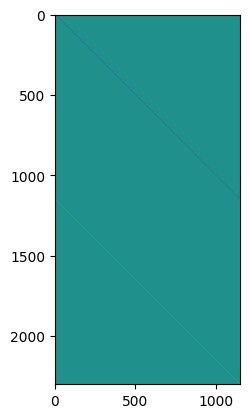

In [48]:
import matplotlib.pyplot as plt
plt.imshow(np.hstack([box_constraints_matr, box_constraints_vec.reshape(-1, 1)]))

We display stacked box constraint matrix with stacked "right part" of inequalities just for diagnostical purposes.

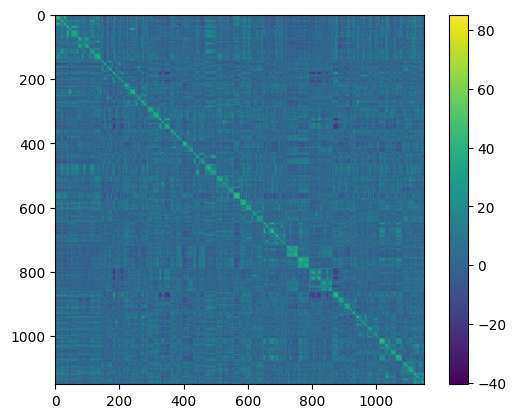

In [49]:
plt.imshow(Q)
plt.colorbar()

Below we use CVXOPT solver - a tool tailored exactly for this kind of tasks. It uses LAPACK and BLAS routines that are industrial-grade fundamental elements for liear algebra toolsets. The task comprising a matrix around 1000 x 1000 is solved at the blink of an eye on a mediocre cheap laptop.

In [50]:
solution = qp(
    matrix(Q),
    matrix(r),
    matrix(box_constraints_matr),
    matrix(box_constraints_vec)
)

     pcost       dcost       gap    pres   dres
 0: -9.1577e+00 -6.1590e+02  4e+03  3e+00  3e-14
 1: -4.9008e+00 -3.0444e+02  4e+02  1e-01  3e-14
 2: -3.3654e-01 -7.3693e+01  9e+01  3e-02  1e-14
 3: -9.5645e-02 -8.3300e+00  1e+01  2e-03  2e-15
 4: -3.3120e-01 -2.1230e+00  2e+00  4e-04  1e-15
 5: -4.5394e-01 -1.0083e+00  6e-01  1e-04  8e-16
 6: -5.1634e-01 -6.6407e-01  1e-01  1e-06  8e-16
 7: -5.4361e-01 -5.8976e-01  5e-02  2e-16  9e-16
 8: -5.5681e-01 -5.5984e-01  3e-03  2e-16  1e-15
 9: -5.5799e-01 -5.5804e-01  6e-05  2e-16  1e-15
10: -5.5801e-01 -5.5801e-01  2e-06  2e-16  1e-15
11: -5.5801e-01 -5.5801e-01  5e-07  2e-16  9e-16
Optimal solution found.


In [51]:
master_vector = np.array(solution['x']).T @ v
master_vector = master_vector / np.linalg.norm(master_vector)
if not PROJECTED_VISUAL_EMBDEDDINGS:
    master_vector = visual_projection_layer(torch.from_numpy(master_vector.astype(np.float32))).detach().numpy()

In [52]:
text_input = tokenizer(
    [
        "visually appealing photo",
        "a professionally-looking photo with nice composition that is worth placing into a photobook",
        "a picture that is not visually appealing"  # negative prompt
    ],
    padding=True, return_tensors="pt"
)
text_embeds = text_encoder(**text_input).text_embeds.detach().numpy()

In [53]:
np.linalg.norm(text_encoder.get_submodule('text_model')(**text_input).pooler_output.detach().numpy(), axis=1)

array([25.800241, 23.283587, 26.45242 ], dtype=float32)

In [54]:
np.linalg.norm(text_embeds, axis=1)

array([12.797175, 10.588998, 13.250759], dtype=float32)

We could expect scalar product magnitudes like the above if both prompt and data-centric aproaches worked perfectly.

In [55]:
text_embeds @ master_vector.T

array([[ 0.04253756],
       [ 0.11445734],
       [-0.1409833 ]])

Dataset is not too rich, so at so high-dimensional embedding space we definitely have a severe overfit, so magnituteds of scalar products are not high, but the coarse mutual semantics of data-centric master-vector and prompt-centric ones is being captured by the sign of products:  
2 upper "positive" prompts have some alignment with data-centric master-vector  
the lower "negative" promts have some anti-alignment with data-centric master vector.

In [41]:
master_vector.shape

(1, 512)

In [56]:
text_embeds.shape

(3, 512)

In [64]:
np.savetxt('master_vectors/data_centric_master_vector.txt', master_vector, delimiter=', ')
np.savetxt('master_vectors/prompt_1.txt', text_embeds[0][np.newaxis, :], delimiter=', ')
np.savetxt('master_vectors/prompt_2.txt', text_embeds[1][np.newaxis, :], delimiter=', ')
np.savetxt('master_vectors/prompt_3.txt', -text_embeds[2][np.newaxis, :], delimiter=', ')